In [1]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina' # retina display mode to make figures crisp 


In [2]:
client = CAVEclient()
3
if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [3]:
downstream_feco_df_all = client.materialize.query_table('downstream_feco_axons_v1')
tenb = downstream_feco_df_all[downstream_feco_df_all.cell_type == '10B']
eightb = downstream_feco_df_all[downstream_feco_df_all.cell_type == '8B']

neuron_info = client.materialize.query_table('neuron_information')
cell_ids = client.materialize.query_table('cell_ids_v2')
proofread_1 = client.materialize.query_table('proofread_first_pass')
proofread_2 = client.materialize.query_table('proofread_second_pass')

In [5]:
upstream = True
syn_thresh = 3
inputs = eightb.pt_root_id.tolist()
if upstream == True:
    syn_df = client.materialize.synapse_query(post_ids = inputs)
else:
    syn_df = client.materialize.synapse_query(pre_ids = inputs)

In [9]:
from my_functions import *
syn_thresh = 3
synapse_df = filt_syn_df(syn_df, syn_thresh)


ModuleNotFoundError: No module named 'my_functions'

In [8]:
# Reference all the proofread neurons to identify % of synapses proofread 
proofread_synapses = 0 

for idx in synapse_df.pre_pt_root_id.tolist(): 
    if idx in proofread_1.pt_root_id.tolist() or idx in proofread_2.pt_root_id.tolist(): 
        proofread_synapses = proofread_synapses + 1 
        
print(proofread_synapses/len(synapse_df))

NameError: name 'synapse_df' is not defined

In [ ]:
# What are the number of unique neurons that are proofread? 

proofread_neurons = 0 

for idx in synapse_df.pre_pt_root_id.unique().tolist(): 
    if idx in proofread_1.pt_root_id.tolist() or idx in proofread_2.pt_root_id.tolist(): 
        proofread_neurons = proofread_neurons + 1 


In [ ]:
# Plot distribution of synapses from each class - reference neuron_info table 
syn_per_conn = synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=["number_of_synapses"]).sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)


In [ ]:
syn_per_conn

In [ ]:
filter_neuron_info = neuron_info[neuron_info.tag.str.contains('motor') |
                                neuron_info.tag.str.contains('sensory') |
                                neuron_info.tag.str.contains('descending') |
                                neuron_info.tag.str.contains('ascending') |
                                neuron_info.tag.str.contains('central')]

filter_neuron_info

In [7]:
get_info = [] 

for idx in syn_per_conn.pre_pt_root_id.tolist(): 
    if idx in proofread_1.pt_root_id.tolist() or idx in proofread_2.pt_root_id.tolist(): 
        if idx in filter_neuron_info.pt_root_id.unique().tolist(): 
            get_info.append(str(filter_neuron_info[filter_neuron_info.pt_root_id == idx].tag.tolist()[0]))
        else: 
            get_info.append('uk')
        
    else: 
        get_info.append('np')
        
syn_per_conn['cell_type'] = get_info
        

NameError: name 'syn_per_conn' is not defined

In [264]:
# Calculate fraction in each group: 
# central, ascending, descending, motor, sensory, np 
central =  syn_per_conn[syn_per_conn.cell_type.str.contains('central')].number_of_synapses.sum()
descending =  syn_per_conn[syn_per_conn.cell_type.str.contains('descending')].number_of_synapses.sum()
ascending = syn_per_conn[syn_per_conn.cell_type.str.contains('ascending')].number_of_synapses.sum()
motor =  syn_per_conn[syn_per_conn.cell_type.str.contains('motor')].number_of_synapses.sum()
sensory = syn_per_conn[syn_per_conn.cell_type.str.contains('sensory')].number_of_synapses.sum()
uk = syn_per_conn[syn_per_conn.cell_type.str.contains('uk')].number_of_synapses.sum()
np = syn_per_conn[syn_per_conn.cell_type.str.contains('np')].number_of_synapses.sum()


# to do: plot distribution 
# convert to fraction 
filler_df = pd.DataFrame()
filler_df['cell_type'] = ['10B']
filler_df['central'] = [central/syn_per_conn.number_of_synapses.sum()]
filler_df['descending'] = [descending/syn_per_conn.number_of_synapses.sum()] 
filler_df['ascending'] = [ascending/syn_per_conn.number_of_synapses.sum()] 
filler_df['motor'] = [motor/syn_per_conn.number_of_synapses.sum()] 
filler_df['sensory'] = [sensory/syn_per_conn.number_of_synapses.sum()] 
filler_df['uk'] = [uk/syn_per_conn.number_of_synapses.sum()] 
filler_df['np'] = [np/syn_per_conn.number_of_synapses.sum()] 

tenb_input = filler_df


In [265]:
tenb_input

,cell_type,central,descending,ascending,motor,sensory,uk,np
0,10B,0.448367,0.000803,0.000482,0.0,0.110278,0.000268,0.439802


Text(0, 0.5, 'synapse fraction')

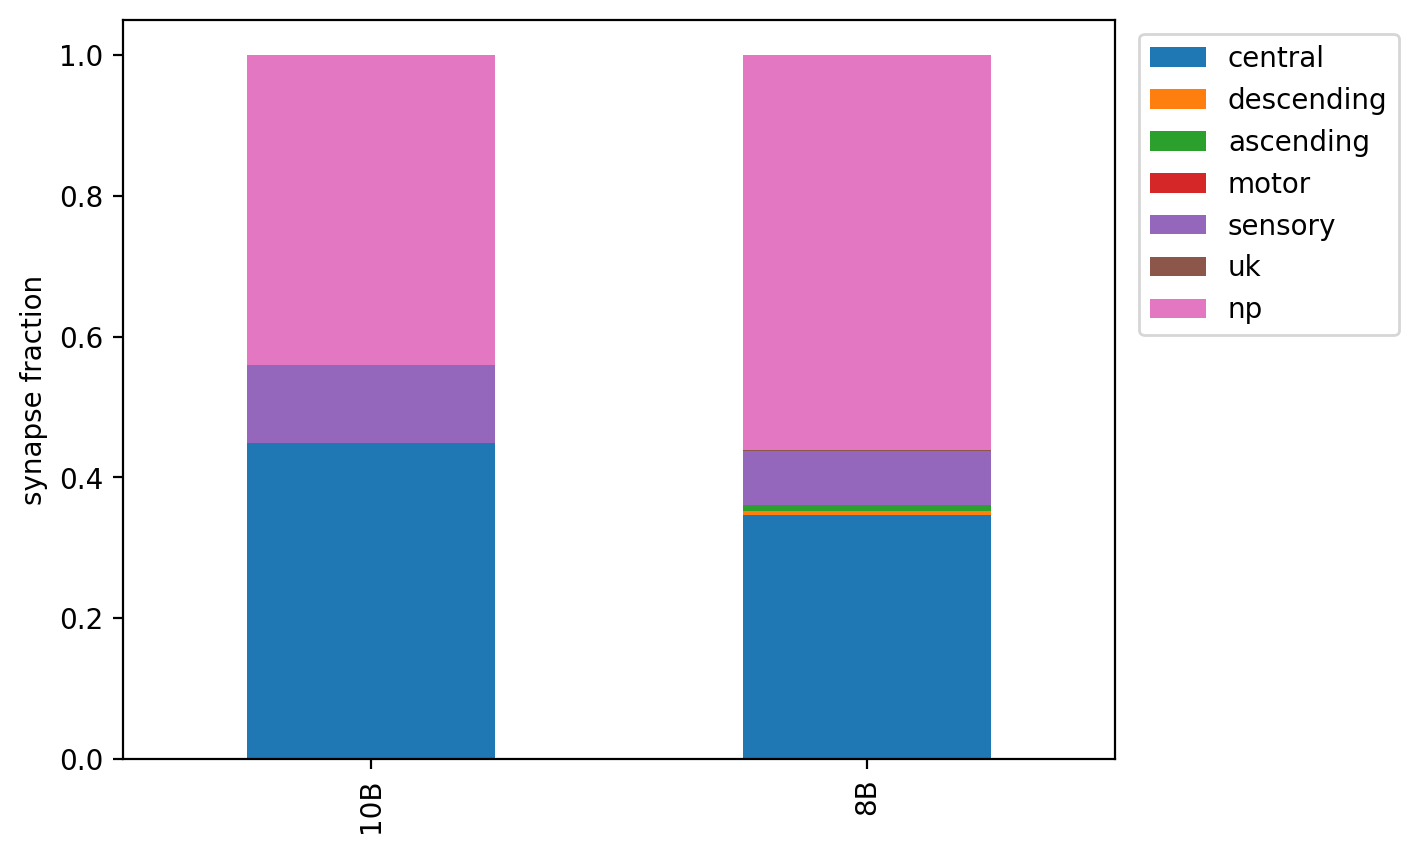

In [286]:
ax = tenb_input.plot(kind='bar', stacked = True)
ax.set_xticklabels(['10B', '8B']) 
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylabel('synapse fraction')

In [ ]:
# Reference sensory tables to get sensory id and plot distribution 

In [291]:
# pull all annotation tables with sensory neuron information 

feco = client.materialize.query_table('feco_axons_v0')
bristle = client.materialize.query_table('bristle_axon_table_v2')
hp = client.materialize.query_table('hair_plate_table')
wing = client.materialize.query_table('wing_premotor_v4') # note classification_system = sensory
abdominal = client.materialize.query_table('abdominal_sensory_axon_table_v0')
cs = client.materialize.query_table('legcs_axons')
wing_admn = client.materialize.query_table('sensory_admn_left')

In [293]:
sensory_all = pd.concat([feco, bristle, hp, wing, abdominal, cs, wing_admn])

In [297]:
sensory_names = []

for idx in syn_table_10b.pre_pt_root_id.tolist(): 
    if idx in sensory_all.pt_root_id.tolist(): 
        sensory_names.append(sensory_all[sensory_all.pt_root_id == idx].cell_type.tolist()[0])
        
    else: 
        sensory_names.append('x')
        
syn_table_10b['sensory_name'] = sensory_names

In [303]:
syn_table_10b[syn_table_10b.cell_type == 'sensory neuron']

,pre_pt_root_id,post_pt_root_id,number_of_synapses,cell_type,sensory_name
763,648518346502655814,648518346485910654,13,sensory neuron,club
764,648518346499960531,648518346465071989,13,sensory neuron,club
771,648518346498554608,648518346499842444,13,sensory neuron,club
777,648518346489700972,648518346496175050,13,sensory neuron,x
781,648518346490488072,648518346496175050,13,sensory neuron,x
795,648518346492913070,648518346496990616,13,sensory neuron,club
797,648518346495414351,648518346474236781,13,sensory neuron,club
800,648518346472537865,648518346494734391,13,sensory neuron,club
802,648518346472537865,648518346477749655,13,sensory neuron,club
805,648518346514007065,648518346499141441,12,sensory neuron,club


In [305]:
sensory_names = []

for idx in syn_table_8b.pre_pt_root_id.tolist(): 
    if idx in sensory_all.pt_root_id.tolist(): 
        sensory_names.append(sensory_all[sensory_all.pt_root_id == idx].cell_type.tolist()[0])
        
    else: 
        sensory_names.append('x')
        
syn_table_10b['sensory_name'] = sensory_names